# Нахождение матрицы траффика

### 1. Теоритическая справка

Рассмотрим сеть некоторого провайдера, ее можно представить в виде некоторых узлов(маршрутизаторов), соединеннных между собой пропускными каналами. Далее введем понятие матрицы трафика. Матрица трафика - это матрица характеризуюзая поток трафика между всеми парами "source" и "destination" (см. рисунок ниже) <img src="data/utils/network_example2.png" alt="drawing" width="600"/>
Такая матрица позволяет понять требования, которыми должно обладать сеть для обеспечения необходимыми ресурсами потребителей, иными словами является отличным интсрументом для планирования развития сетевой инфраструктуры, понимания ее узких мест и грамотного реагирования на внештатные ситуации.

Построение матрицы трафика непосредственно путем маркировки пакетов на входах/выходах трафика накладывает большую нагрузку на вычислительные мощности оборудования, поэтому в некоторых коммерческих ПО для этого используются математические методы, основанные на информации о загрузке линков полученные из протоколов SNMP, NetFlow.


В моей дипломной работе в качестве финального продукта подразумевается создание ПО для мониторинга сетевой инфраструктуры. В рамках данного отчета я хотел бы попробовать реализовать mvp модуля решающего проблему, описанную выше.
 

tensor(20.2373)
tensor(20.2361)
tensor(20.0932)


Text(0.5, 0, 'z')

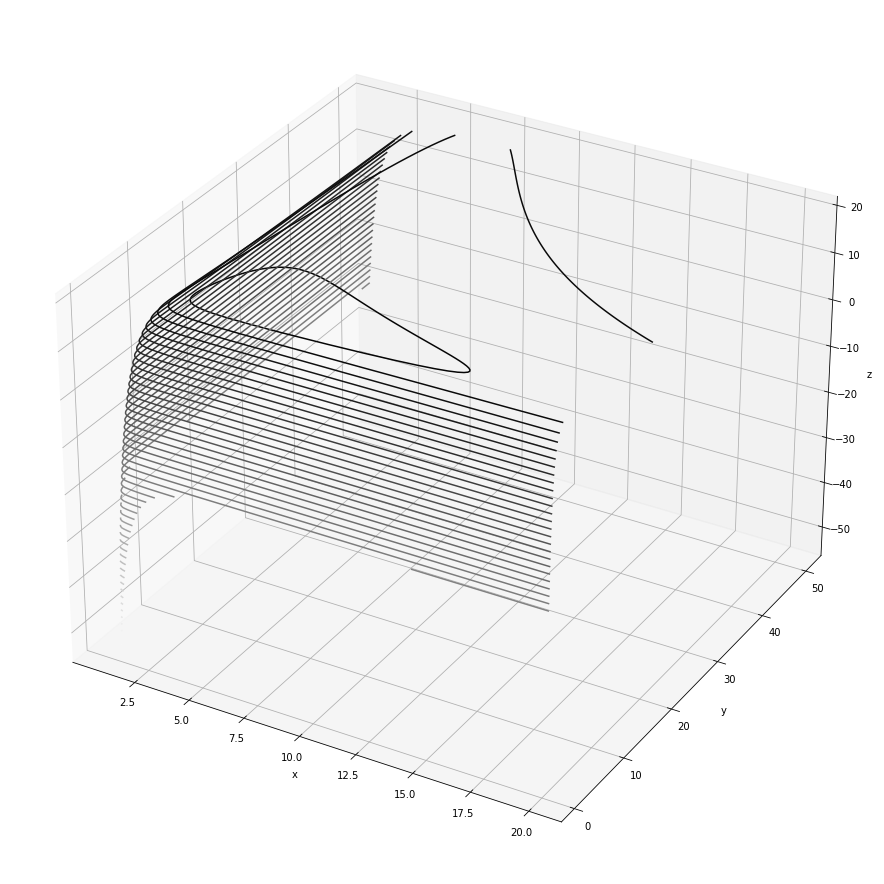

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def f(w, q):
    phi = 1
    y = torch.Tensor([0, 10, 10, 0])
    A = torch.Tensor([[0,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,0]]) + 0.01 * torch.eye(4)
    lambdas = torch.Tensor([0.0001, w, q, 0.001])
    sigma = phi * torch.pow(torch.diag(lambdas), 2)
    try:
        torch.inverse(A@sigma@A.T)
    except torch._C._LinAlgError:
        return 0
    likelihood = - 0.5 * torch.log(torch.det(A@sigma@A.T))
    likelihood -= 0.5 * (y - A @ lambdas).T @ torch.inverse(A@sigma@A.T) @ (y-A@lambdas)
    return likelihood

def create_Z(x,y):
    Z = [[0 for i in range(len(x))] for j in range(len(y))] 
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i][j] = f(x[i][j], y[i][j])    
    return Z


x = np.linspace(1, 20, 200)
y = np.linspace(1, 50, 200)

X, Y = np.meshgrid(x, y)
Z = create_Z(X, Y)

print(f(7.0632,7.0632))
print(f(7.0732,7.0732))
print(f(8,8))

fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 60, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### 2. Реализация&Ручное тестирование

In [4]:
%reload_ext autoreload

import torch
import models
import solvers.likelihood_method as likelihood_method
import numpy as np
import matplotlib.pyplot as plt

"""
[1]<----10---->[2]
"""
graph = torch.Tensor([[1, 1], [1, 1]])
networkModel = models.NetworkModel(graph=graph)
networkModel.set_link_load(
links_weights_hist=[[models.LinkWeight(i=0,j=1,weight=10), models.LinkWeight(i=1,j=0,weight=10)]])

likelihood_solver = likelihood_method.TMSolver_LikelihoodMethod(show_plt=True, max_grad_dec=1500)
res = likelihood_solver.get_optimal_solution(networkModel)
print(res)

(Parameter containing:
tensor([1.0000e-04, 7.0407e+00, 7.0407e+00, 1.0000e-04], requires_grad=True), Parameter containing:
tensor(0.5878, dtype=torch.float64, requires_grad=True))


loss_historyX [tensor(2.3207)]
loss_historyY [tensor(1.8471)]


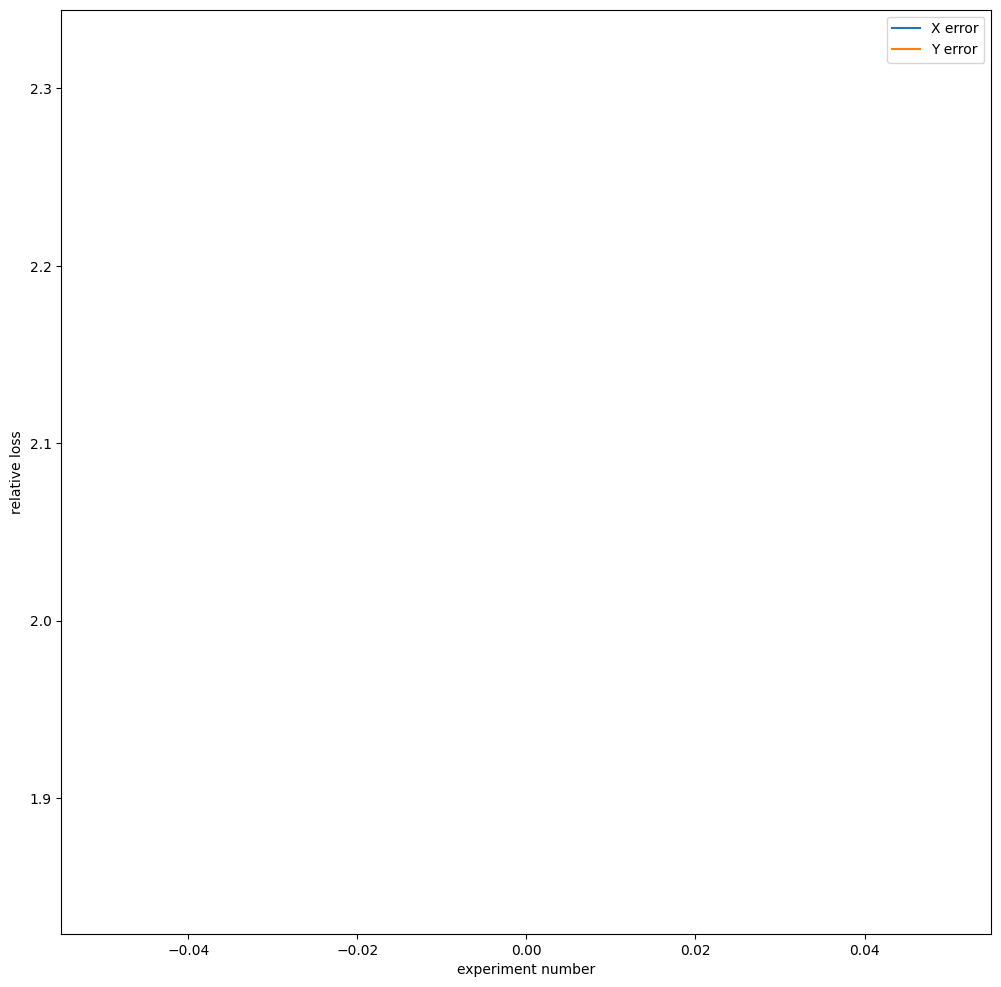

In [1]:
import torch
import models
import solvers.likelihood_method as likelihood_method
import numpy as np
import benchmark_util
import solvers.mse_method


graph = torch.Tensor(torch.Tensor([
        [0, 1, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ]))
TM_hist = [
    [
        [0, 5, 10, 0],
        [0, 0, 0, 5],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ],
]
b = benchmark_util.BenchmarkUtil(graph=graph, TM_hist=TM_hist)
w = [0] * 16
w[1] = 1
b.activate_netflow_in_model(w)

mse_solver = solvers.mse_method.TMSolver_MSEMethod(max_grad_dec = 50, show_plt=True)
b.show_benchmark_for_last_TM(mse_solver)

## Тестируем на датасете матриц трафика

<img src="data/utils/bso-topo.png" alt="drawing" width="400"/>

### Метод MSE

In [15]:
import torch
torch.__version__

'1.13.0'

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

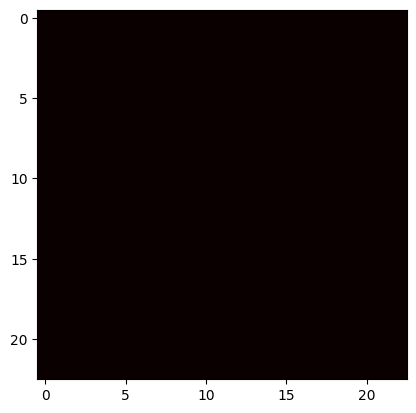

In [5]:
import benchmark_util
import solvers.mse_method

mse_solver = solvers.mse_method.TMSolver_MSEMethod(max_grad_dec = 50, show_plt=True)
benchmark_util.benchmark_solver(mse_solver, test_cases_size=1, history_size = 1, debug=False)


### Метод likelihood


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

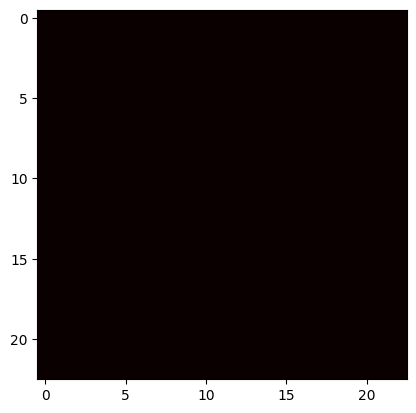

In [6]:
import benchmark_util
import solvers.likelihood_method2

mse_solver = solvers.likelihood_method2.TMSolver_LikelihoodMethod(max_grad_dec = 1000)
benchmark_util.benchmark_solver(mse_solver, test_cases_size=2, history_size = 20)